In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cactas as C
import os
import mahotas as mh
import cv2

In [3]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

2024-05-13 19:08:55.784568: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-05-13 19:08:57.624296: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-13 19:08:57.625266: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-05-13 19:08:58.006193: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-13 19:08:58.008707: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:0f:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 3

True

In [4]:
DATAPATH='/raid/mpsych/CACTAS/DATA/CLEANED/'

In [5]:
data = C.Helper.load_separate_data(DATAPATH, 
                    types=('filt_img', 'filt_lb', 'filt_msk'), subsets=('train', 'test'))

In [6]:
filtered_images_train = data['filt_img_train']
filtered_images_test = data['filt_img_test']
filtered_labels_train = data['filt_lb_train']
filtered_labels_test = data['filt_lb_test']
filtered_masks_train = data['filt_msk_train']
filtered_masks_test = data['filt_msk_test']

In [7]:
normalized_images_train = C.Helper.normalize_data(filtered_images_train)
normalized_images_test = C.Helper.normalize_data(filtered_images_test)

In [8]:
normalized_masks_train = C.Helper.normalize_data(filtered_masks_train)
normalized_masks_test = C.Helper.normalize_data(filtered_masks_test)

In [9]:
last_key = np.concatenate(normalized_images_train[:round(len(normalized_images_train)*0.8)], axis=0)

In [10]:
X_train = np.concatenate(normalized_images_train, axis=0)
X_test = np.concatenate(normalized_images_test, axis=0)
y_train_array = np.concatenate(filtered_labels_train, axis=0)
y_test_array = np.concatenate(filtered_labels_test, axis=0)
m_train = np.concatenate(normalized_masks_train, axis=0)
m_test = np.concatenate(normalized_masks_test, axis=0)

In [11]:
new_slices = []
for i in range(len(y_train_array)):
    slices = np.where(y_train_array[i] != 0, True, False)
    new_slices.append(slices)
y_train = np.array(new_slices)

In [12]:
new_slices1 = []
for i in range(len(y_test_array)):
    slices = np.where(y_test_array[i] != 0, True, False)
    new_slices1.append(slices)
y_test = np.array(new_slices1)

In [13]:
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

In [14]:
train_masks=[]
for i in range(len(m_train)):
    binary = (m_train[i] > 0).astype(np.uint8)
    dilated = mh.dilate(binary.astype(np.bool_))
    for _ in range(9):
        dilated = mh.dilate(dilated)
    train_masks.append(dilated)

In [15]:
train_images=[]
for i in range(len(X_train)):
    train_image = X_train[i] * train_masks[i]
    train_images.append(train_image)
train_images_array = np.array(train_images)

In [16]:
test_masks=[]
for i in range(len(m_test)):
    binary = (m_test[i] > 0).astype(np.uint8)
    dilated = mh.dilate(binary.astype(np.bool_))
    for _ in range(9):
        dilated = mh.dilate(dilated)
    test_masks.append(dilated)

In [17]:
test_images=[]
for i in range(len(X_test)):
    test_image = X_test[i] * test_masks[i]
    test_images.append(test_image)
test_images_array = np.array(test_images)

In [18]:
X_train_set = train_images_array[:last_key.shape[0]]
y_train_set = y_train[:last_key.shape[0]]
X_val = train_images_array[last_key.shape[0]:]
y_val = y_train[last_key.shape[0]:]

In [19]:
X_train = []
y_train = []
X_val_set = []
y_val_set = []

In [20]:
for i in range(X_train_set.shape[0]):
    X_train.append(X_train_set[i][100:400,100:400])
    y_train.append(y_train_set[i][100:400,100:400])

In [21]:
for i in range(X_val.shape[0]):
    X_val_set.append(X_val[i][100:400,100:400])
    y_val_set.append(y_val[i][100:400,100:400])

In [22]:
def resize_images(arrays, new_size=(256, 256)):
    resized_images = []
    for img in arrays:
        resized_img = cv2.resize(img, new_size)
        resized_images.append(resized_img)
    return np.array(resized_images)

In [23]:
new_size = (256, 256)
X_train_resized = resize_images(X_train, new_size)
y_train_resized = resize_images(y_train, new_size)
X_val_resized = resize_images(X_val_set, new_size)
y_val_resized = resize_images(y_val_set, new_size)
X_test_resized = resize_images(test_images_array, new_size)
y_test_resized = resize_images(y_test, new_size)

In [24]:
X_train_resized = X_train_resized.reshape(X_train_resized.shape[0], X_train_resized.shape[1],X_train_resized.shape[2], 1)
y_train_resized = y_train_resized.reshape(y_train_resized.shape[0], y_train_resized.shape[1],y_train_resized.shape[2], 1)
X_val_resized = X_val_resized.reshape(X_val_resized.shape[0], X_val_resized.shape[1],X_val_resized.shape[2], 1)
y_val_resized = y_val_resized.reshape(y_val_resized.shape[0], y_val_resized.shape[1],y_val_resized.shape[2], 1)
X_test_resized = X_test_resized.reshape(X_test_resized.shape[0], X_test_resized.shape[1],X_test_resized.shape[2], 1)
y_test_resized = y_test_resized.reshape(y_test_resized.shape[0], y_test_resized.shape[1],y_test_resized.shape[2], 1)

In [25]:
# for i in range(len(X_train_resized)):
#     plt.imshow(X_train_resized[i])
#     plt.imshow(y_train_resized[i], cmap='gray', alpha=0.5)
#     plt.show()

In [26]:
# for i in range(len(X_val_resized)):
#     plt.imshow(X_val_resized[i])
#     plt.imshow(y_val_resized[i], cmap='gray', alpha=0.5)
#     plt.show()

In [27]:
model = C.Helper.create_unet(X_train_resized[0].shape)

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


2024-05-13 19:09:12.698589: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-13 19:09:12.702763: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:0f:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-13 19:09:12.718970: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible gpu devices: 0, 1
2024-05-13 19:09:12.724664: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:07:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-05-13 19:09:12.728638: I tensorflow/core

In [28]:
model, history = C.Helper.train_unet(X_train_resized, y_train_resized, X_val_resized, y_val_resized, model, epochs=500)

2024-05-13 19:09:13.341590: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2024-05-13 19:09:13.366762: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2245740000 Hz


Epoch 1/500


2024-05-13 19:09:14.668728: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-05-13 19:09:15.293133: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2024-05-13 19:09:15.934985: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2024-05-13 19:09:15.935009: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-05-13 19:09:15.935064: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-13 19:09:15.986898: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-05-13 19:09:16.694607: I tensorflow/stream_exec

11/11 [==============================] - 17s 616ms/step - loss: 2.1122 - iou: 2.3317e-04 - iou_thresholded: 8.7628e-04 - val_loss: 0.6235 - val_iou: 1.4195e-04 - val_iou_thresholded: 0.0014
Epoch 2/500
11/11 [==============================] - 4s 193ms/step - loss: 0.2355 - iou: 2.2526e-04 - iou_thresholded: 0.0026 - val_loss: 0.0253 - val_iou: 3.6730e-05 - val_iou_thresholded: 0.0014
Epoch 3/500
11/11 [==============================] - 2s 176ms/step - loss: 0.0171 - iou: 2.6262e-04 - iou_thresholded: 0.0054 - val_loss: 0.0065 - val_iou: 4.5888e-04 - val_iou_thresholded: 0.0014
Epoch 4/500
11/11 [==============================] - 2s 176ms/step - loss: 0.0063 - iou: 0.0012 - iou_thresholded: 0.0029 - val_loss: 0.0022 - val_iou: 0.0057 - val_iou_thresholded: 0.0014
Epoch 5/500
11/11 [==============================] - 2s 177ms/step - loss: 0.0041 - iou: 0.0052 - iou_thresholded: 0.0073 - val_loss: 0.0023 - val_iou: 0.0028 - val_iou_thresholded: 0.0014
Epoch 6/500
11/11 [===================

11/11 [==============================] - 2s 176ms/step - loss: 0.0018 - iou: 0.1678 - iou_thresholded: 0.2212 - val_loss: 0.0015 - val_iou: 0.1288 - val_iou_thresholded: 0.1589
Epoch 45/500
11/11 [==============================] - 2s 176ms/step - loss: 0.0020 - iou: 0.1587 - iou_thresholded: 0.2610 - val_loss: 0.0019 - val_iou: 0.0264 - val_iou_thresholded: 0.0071
Epoch 46/500
11/11 [==============================] - 2s 177ms/step - loss: 0.0019 - iou: 0.1137 - iou_thresholded: 0.1250 - val_loss: 0.0017 - val_iou: 0.0376 - val_iou_thresholded: 0.0120
Epoch 47/500
11/11 [==============================] - 2s 177ms/step - loss: 0.0016 - iou: 0.1743 - iou_thresholded: 0.2358 - val_loss: 0.0014 - val_iou: 0.1033 - val_iou_thresholded: 0.1292
Epoch 48/500
11/11 [==============================] - 2s 176ms/step - loss: 0.0015 - iou: 0.1733 - iou_thresholded: 0.2636 - val_loss: 0.0013 - val_iou: 0.1391 - val_iou_thresholded: 0.1319
Epoch 49/500
11/11 [==============================] - 2s 191ms/

11/11 [==============================] - 2s 192ms/step - loss: 7.9319e-04 - iou: 0.4572 - iou_thresholded: 0.5595 - val_loss: 9.9420e-04 - val_iou: 0.3491 - val_iou_thresholded: 0.4352
Epoch 87/500
11/11 [==============================] - 2s 178ms/step - loss: 8.0815e-04 - iou: 0.4367 - iou_thresholded: 0.5474 - val_loss: 0.0011 - val_iou: 0.3239 - val_iou_thresholded: 0.3723
Epoch 88/500
11/11 [==============================] - 2s 181ms/step - loss: 7.6048e-04 - iou: 0.4622 - iou_thresholded: 0.5771 - val_loss: 0.0011 - val_iou: 0.3323 - val_iou_thresholded: 0.3884
Epoch 89/500
11/11 [==============================] - 2s 176ms/step - loss: 7.4127e-04 - iou: 0.4316 - iou_thresholded: 0.5329 - val_loss: 0.0011 - val_iou: 0.3347 - val_iou_thresholded: 0.4183
Epoch 90/500
11/11 [==============================] - 2s 176ms/step - loss: 7.8568e-04 - iou: 0.4640 - iou_thresholded: 0.5829 - val_loss: 0.0012 - val_iou: 0.3162 - val_iou_thresholded: 0.3673
Epoch 91/500
11/11 [===================

11/11 [==============================] - 2s 177ms/step - loss: 5.4762e-04 - iou: 0.5016 - iou_thresholded: 0.6013 - val_loss: 0.0013 - val_iou: 0.3501 - val_iou_thresholded: 0.4099
Epoch 129/500
11/11 [==============================] - 2s 176ms/step - loss: 5.7376e-04 - iou: 0.5153 - iou_thresholded: 0.6095 - val_loss: 0.0016 - val_iou: 0.3308 - val_iou_thresholded: 0.3580
Epoch 130/500
11/11 [==============================] - 2s 176ms/step - loss: 5.6031e-04 - iou: 0.5380 - iou_thresholded: 0.6459 - val_loss: 0.0013 - val_iou: 0.3381 - val_iou_thresholded: 0.3888
Epoch 131/500
11/11 [==============================] - 2s 176ms/step - loss: 6.4840e-04 - iou: 0.5065 - iou_thresholded: 0.6092 - val_loss: 0.0015 - val_iou: 0.3173 - val_iou_thresholded: 0.3718
Epoch 132/500
11/11 [==============================] - 2s 176ms/step - loss: 6.4222e-04 - iou: 0.4723 - iou_thresholded: 0.6038 - val_loss: 0.0011 - val_iou: 0.3700 - val_iou_thresholded: 0.4245
Epoch 133/500
11/11 [==================

11/11 [==============================] - 2s 193ms/step - loss: 4.4205e-04 - iou: 0.5779 - iou_thresholded: 0.6769 - val_loss: 0.0016 - val_iou: 0.3622 - val_iou_thresholded: 0.4109
Epoch 171/500
11/11 [==============================] - 2s 176ms/step - loss: 4.4945e-04 - iou: 0.6131 - iou_thresholded: 0.7112 - val_loss: 0.0013 - val_iou: 0.3992 - val_iou_thresholded: 0.4498
Epoch 172/500
11/11 [==============================] - 2s 176ms/step - loss: 4.4172e-04 - iou: 0.6167 - iou_thresholded: 0.7108 - val_loss: 0.0013 - val_iou: 0.3953 - val_iou_thresholded: 0.4544
Epoch 173/500
11/11 [==============================] - 2s 176ms/step - loss: 4.5503e-04 - iou: 0.6061 - iou_thresholded: 0.7025 - val_loss: 0.0014 - val_iou: 0.3758 - val_iou_thresholded: 0.4310
Epoch 174/500
11/11 [==============================] - 2s 177ms/step - loss: 4.1946e-04 - iou: 0.5835 - iou_thresholded: 0.6851 - val_loss: 0.0015 - val_iou: 0.3632 - val_iou_thresholded: 0.4170
Epoch 175/500
11/11 [==================

11/11 [==============================] - 2s 176ms/step - loss: 4.2291e-04 - iou: 0.6238 - iou_thresholded: 0.7190 - val_loss: 0.0016 - val_iou: 0.3855 - val_iou_thresholded: 0.4285
Epoch 213/500
11/11 [==============================] - 2s 176ms/step - loss: 4.1309e-04 - iou: 0.6231 - iou_thresholded: 0.7229 - val_loss: 0.0016 - val_iou: 0.3734 - val_iou_thresholded: 0.4218
Epoch 214/500
11/11 [==============================] - 2s 176ms/step - loss: 3.7680e-04 - iou: 0.6268 - iou_thresholded: 0.7224 - val_loss: 0.0016 - val_iou: 0.3523 - val_iou_thresholded: 0.4007
Epoch 215/500
11/11 [==============================] - 2s 177ms/step - loss: 3.9579e-04 - iou: 0.6451 - iou_thresholded: 0.7347 - val_loss: 0.0020 - val_iou: 0.3546 - val_iou_thresholded: 0.3856
Epoch 216/500
11/11 [==============================] - 2s 176ms/step - loss: 3.8659e-04 - iou: 0.6338 - iou_thresholded: 0.7302 - val_loss: 0.0018 - val_iou: 0.3528 - val_iou_thresholded: 0.3982
Epoch 217/500
11/11 [==================

11/11 [==============================] - 2s 191ms/step - loss: 3.8539e-04 - iou: 0.6418 - iou_thresholded: 0.7329 - val_loss: 0.0015 - val_iou: 0.3617 - val_iou_thresholded: 0.4149
Epoch 255/500
11/11 [==============================] - 2s 176ms/step - loss: 3.9177e-04 - iou: 0.6433 - iou_thresholded: 0.7323 - val_loss: 0.0016 - val_iou: 0.3776 - val_iou_thresholded: 0.4151
Epoch 256/500
11/11 [==============================] - 2s 177ms/step - loss: 3.8364e-04 - iou: 0.6483 - iou_thresholded: 0.7445 - val_loss: 0.0015 - val_iou: 0.3800 - val_iou_thresholded: 0.4320
Epoch 257/500
11/11 [==============================] - 2s 176ms/step - loss: 3.7374e-04 - iou: 0.6693 - iou_thresholded: 0.7582 - val_loss: 0.0017 - val_iou: 0.3867 - val_iou_thresholded: 0.4241
Epoch 258/500
11/11 [==============================] - 2s 177ms/step - loss: 3.5101e-04 - iou: 0.6687 - iou_thresholded: 0.7526 - val_loss: 0.0017 - val_iou: 0.3809 - val_iou_thresholded: 0.4179
Epoch 259/500
11/11 [==================

11/11 [==============================] - 2s 176ms/step - loss: 3.1592e-04 - iou: 0.6912 - iou_thresholded: 0.7751 - val_loss: 0.0016 - val_iou: 0.3970 - val_iou_thresholded: 0.4350
Epoch 297/500
11/11 [==============================] - 2s 176ms/step - loss: 3.2536e-04 - iou: 0.6879 - iou_thresholded: 0.7723 - val_loss: 0.0015 - val_iou: 0.3929 - val_iou_thresholded: 0.4295
Epoch 298/500
11/11 [==============================] - 2s 177ms/step - loss: 3.1543e-04 - iou: 0.6884 - iou_thresholded: 0.7644 - val_loss: 0.0017 - val_iou: 0.3945 - val_iou_thresholded: 0.4256
Epoch 299/500
11/11 [==============================] - 2s 176ms/step - loss: 3.1317e-04 - iou: 0.6988 - iou_thresholded: 0.7772 - val_loss: 0.0019 - val_iou: 0.3704 - val_iou_thresholded: 0.4040
Epoch 300/500
11/11 [==============================] - 2s 176ms/step - loss: 3.0931e-04 - iou: 0.6948 - iou_thresholded: 0.7791 - val_loss: 0.0017 - val_iou: 0.3770 - val_iou_thresholded: 0.4150
Epoch 301/500
11/11 [==================

11/11 [==============================] - 2s 192ms/step - loss: 2.9676e-04 - iou: 0.7084 - iou_thresholded: 0.7832 - val_loss: 0.0014 - val_iou: 0.4199 - val_iou_thresholded: 0.4598
Epoch 339/500
11/11 [==============================] - 2s 176ms/step - loss: 2.8385e-04 - iou: 0.6986 - iou_thresholded: 0.7801 - val_loss: 0.0016 - val_iou: 0.4135 - val_iou_thresholded: 0.4463
Epoch 340/500
11/11 [==============================] - 2s 176ms/step - loss: 3.1258e-04 - iou: 0.7235 - iou_thresholded: 0.7954 - val_loss: 0.0016 - val_iou: 0.4031 - val_iou_thresholded: 0.4405
Epoch 341/500
11/11 [==============================] - 2s 177ms/step - loss: 2.9311e-04 - iou: 0.7177 - iou_thresholded: 0.7909 - val_loss: 0.0017 - val_iou: 0.4031 - val_iou_thresholded: 0.4365
Epoch 342/500
11/11 [==============================] - 2s 177ms/step - loss: 2.8989e-04 - iou: 0.7186 - iou_thresholded: 0.7926 - val_loss: 0.0016 - val_iou: 0.4052 - val_iou_thresholded: 0.4419
Epoch 343/500
11/11 [==================

11/11 [==============================] - 2s 177ms/step - loss: 2.8261e-04 - iou: 0.7144 - iou_thresholded: 0.7898 - val_loss: 0.0017 - val_iou: 0.3896 - val_iou_thresholded: 0.4258
Epoch 381/500
11/11 [==============================] - 2s 176ms/step - loss: 2.8240e-04 - iou: 0.7242 - iou_thresholded: 0.7952 - val_loss: 0.0016 - val_iou: 0.4018 - val_iou_thresholded: 0.4420
Epoch 382/500
11/11 [==============================] - 2s 176ms/step - loss: 2.9652e-04 - iou: 0.6976 - iou_thresholded: 0.7784 - val_loss: 0.0017 - val_iou: 0.3957 - val_iou_thresholded: 0.4362
Epoch 383/500
11/11 [==============================] - 2s 176ms/step - loss: 2.8890e-04 - iou: 0.6978 - iou_thresholded: 0.7751 - val_loss: 0.0017 - val_iou: 0.4047 - val_iou_thresholded: 0.4360
Epoch 384/500
11/11 [==============================] - 2s 180ms/step - loss: 2.9402e-04 - iou: 0.7183 - iou_thresholded: 0.7910 - val_loss: 0.0014 - val_iou: 0.4134 - val_iou_thresholded: 0.4610
Epoch 385/500
11/11 [==================

11/11 [==============================] - 2s 192ms/step - loss: 2.9866e-04 - iou: 0.7120 - iou_thresholded: 0.7866 - val_loss: 0.0019 - val_iou: 0.3959 - val_iou_thresholded: 0.4309
Epoch 423/500
11/11 [==============================] - 2s 176ms/step - loss: 2.7932e-04 - iou: 0.7207 - iou_thresholded: 0.7887 - val_loss: 0.0019 - val_iou: 0.3860 - val_iou_thresholded: 0.4199
Epoch 424/500
11/11 [==============================] - 2s 176ms/step - loss: 2.9538e-04 - iou: 0.7281 - iou_thresholded: 0.7982 - val_loss: 0.0024 - val_iou: 0.3685 - val_iou_thresholded: 0.3985
Epoch 425/500
11/11 [==============================] - 2s 177ms/step - loss: 2.8122e-04 - iou: 0.7173 - iou_thresholded: 0.7894 - val_loss: 0.0029 - val_iou: 0.3592 - val_iou_thresholded: 0.3916
Epoch 426/500
11/11 [==============================] - 2s 176ms/step - loss: 2.7778e-04 - iou: 0.7282 - iou_thresholded: 0.8024 - val_loss: 0.0027 - val_iou: 0.3664 - val_iou_thresholded: 0.3979
Epoch 427/500
11/11 [==================

11/11 [==============================] - 2s 176ms/step - loss: 2.7338e-04 - iou: 0.7432 - iou_thresholded: 0.8056 - val_loss: 0.0016 - val_iou: 0.3983 - val_iou_thresholded: 0.4381
Epoch 465/500
11/11 [==============================] - 2s 176ms/step - loss: 2.6474e-04 - iou: 0.7316 - iou_thresholded: 0.7979 - val_loss: 0.0019 - val_iou: 0.3893 - val_iou_thresholded: 0.4200
Epoch 466/500
11/11 [==============================] - 2s 177ms/step - loss: 2.7786e-04 - iou: 0.7340 - iou_thresholded: 0.8021 - val_loss: 0.0020 - val_iou: 0.3850 - val_iou_thresholded: 0.4189
Epoch 467/500
11/11 [==============================] - 2s 176ms/step - loss: 2.6816e-04 - iou: 0.7375 - iou_thresholded: 0.8008 - val_loss: 0.0018 - val_iou: 0.4029 - val_iou_thresholded: 0.4337
Epoch 468/500
11/11 [==============================] - 2s 176ms/step - loss: 2.7148e-04 - iou: 0.7352 - iou_thresholded: 0.8008 - val_loss: 0.0016 - val_iou: 0.4129 - val_iou_thresholded: 0.4480
Epoch 469/500
11/11 [==================

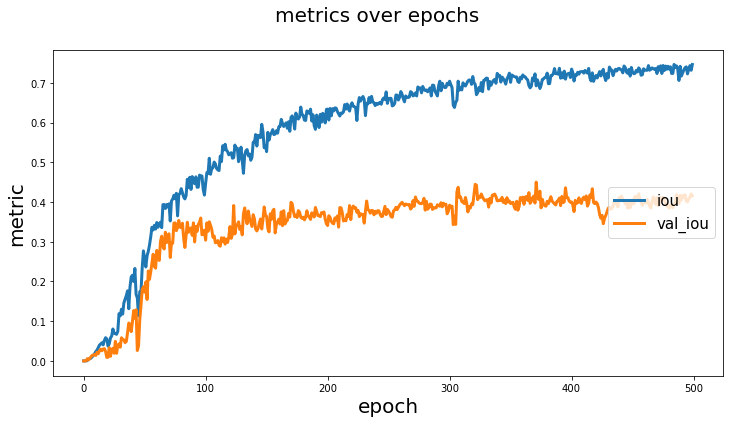

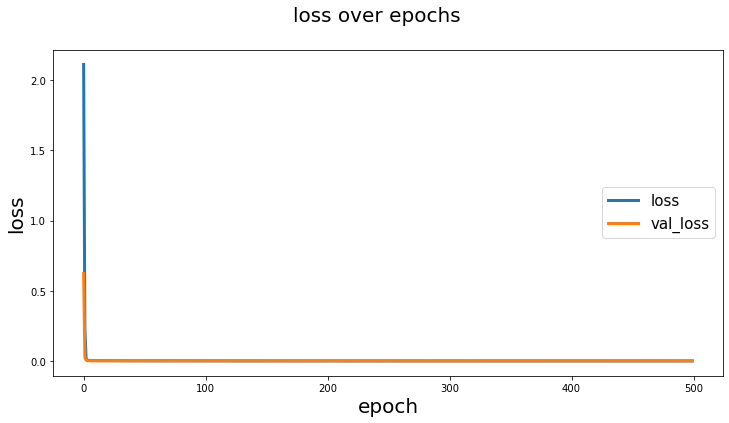

In [29]:
C.Helper.visualize_graph(history)

In [30]:
y_pred = C.Helper.prediction(X_test_resized, model)

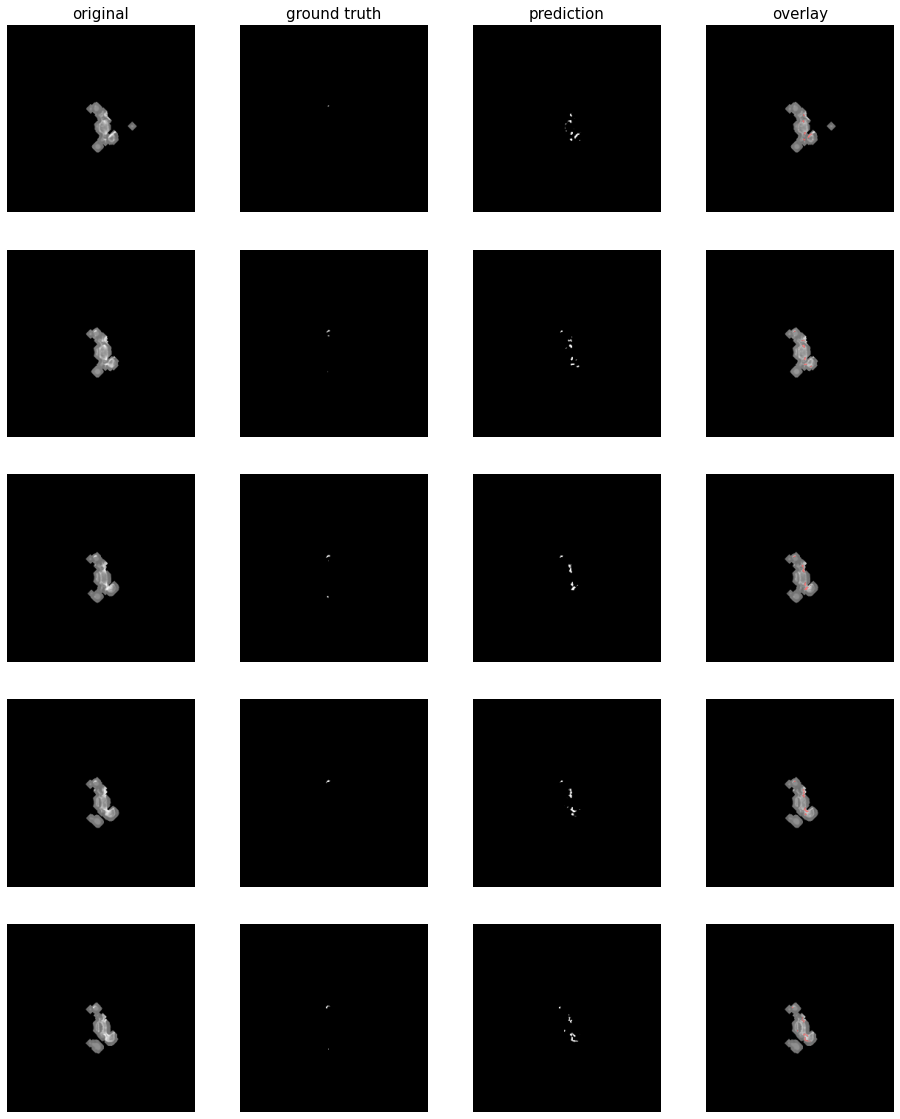

In [31]:
C.Helper.visualize_result(X_test_resized, y_test_resized, y_pred)

In [32]:
C.Helper.evaluate(X_test_resized, y_test_resized, model)

9/9 [==============================] - 0s 49ms/step - loss: 0.0026 - iou: 0.1762 - iou_thresholded: 0.1895
